# $R^2$ as weights for the integration from insertion-level to gene-level

For data without biological replicates, there is no way to calculate the standard deviation and the p-value.

In this notebook, we will use the $R^2$ as the weights for the integration from insertion-level to gene-level.



In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr

## 1. Load the input files

Insertion-level curve fitting result: `/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/16_insertion_level_curve_fitting_new/insertions_LFC_fitted.tsv`

Insertion annotation: `/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/12_concatenated/annotations.tsv`

In [106]:
ins_res = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/16_insertion_level_curve_fitting_new/insertions_LFC_fitted.tsv", sep="\t", index_col=[0,1,2,3])
p_values = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/15_insertion_level_depletion_analysis/padj.tsv", sep="\t", index_col=[0,1,2,3])

annotations = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/12_concatenated/annotations.tsv", sep="\t", index_col=[0,1,2,3])

In [108]:
ins_res.filter(regex=r"^t(\d+)$").astype(float)

t0     t1     t2     t3     t4
Chr           Coordinate Strand Target                                 
I             13506      +      TTAA    0.0  2.415  0.929 -0.284 -0.193
              14027      +      TTAA    0.0  0.500  0.950  1.134  1.823
              14304      -      TTAA    0.0 -0.037  0.332 -0.020  0.147
              14497      +      TTAA    0.0 -0.171  0.011  0.127 -0.122
              14930      +      TTAA    0.0  0.358  0.027  0.239  0.418
...                                     ...    ...    ...    ...    ...
mitochondrial 9747       -      TTAA    0.0 -0.046 -0.507  0.258 -0.629
              13543      +      TATT    0.0 -0.230 -0.380 -0.349 -0.679
                         -      TATT    0.0 -0.098 -1.253 -0.387 -1.474
              15384      +      ATTA    0.0 -0.281 -1.217 -0.000 -1.253
                         -      ATTA    0.0  0.482 -1.356  0.549 -1.399

[93631 rows x 5 columns]

## 2. Define the in-gene insertions

In [8]:
in_gene_ins = annotations.query("Type != 'integenic region' and Distance_to_stop_codon > 4")

## 3. Compare the $R^2$ and p-value

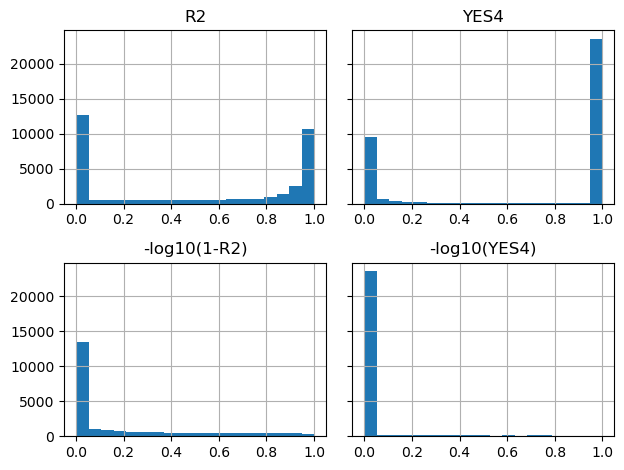

In [74]:
R2_and_YES4_padj = pd.merge(ins_res["R2"], p_values["YES4"], left_index=True, right_index=True)
R2_and_YES4_padj["R2"] = R2_and_YES4_padj["R2"].clip(lower=1e-3, upper=1-1e-3) 
R2_and_YES4_padj["YES4"] = R2_and_YES4_padj["YES4"].clip(lower=1e-3, upper=1-1e-3) 
R2_and_YES4_padj["-log10(1-R2)"] = -np.log10(1-R2_and_YES4_padj["R2"])
R2_and_YES4_padj["-log10(YES4)"] = -np.log10(R2_and_YES4_padj["YES4"])
in_gene_R2_and_YES4_padj = R2_and_YES4_padj[R2_and_YES4_padj.index.isin(in_gene_ins.index)].dropna()
in_gene_R2_and_YES4_padj.hist(bins=np.linspace(0, 1, 20), layout=(2,2), sharey=True)
plt.tight_layout()
plt.show()
plt.close()

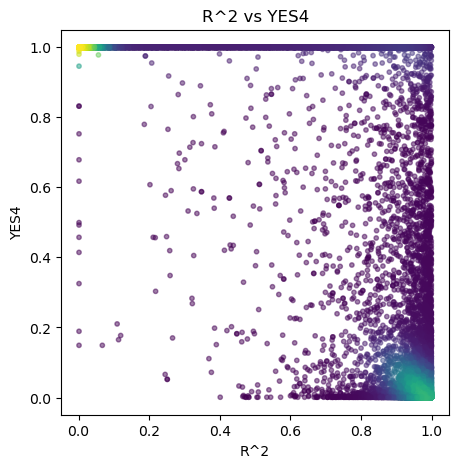

In [62]:
fig, ax = plt.subplots(figsize=(5, 5))

x = in_gene_R2_and_YES4_padj["R2"]
y = in_gene_R2_and_YES4_padj["YES4"]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

ax.scatter(x, y, alpha=0.5, c=z, s=10)
ax.set_xlabel("R^2")
ax.set_ylabel("YES4")
ax.set_title("R^2 vs YES4")
plt.show()
plt.close()

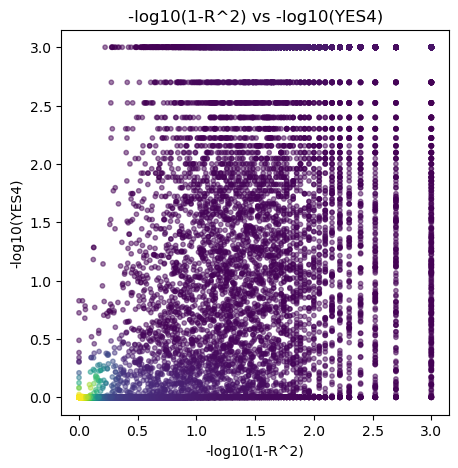

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))

x = in_gene_R2_and_YES4_padj["-log10(1-R2)"]
y = in_gene_R2_and_YES4_padj["-log10(YES4)"]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

ax.scatter(x, y, alpha=0.5, c=z, s=10)
ax.set_xlabel("-log10(1-R^2)")
ax.set_ylabel("-log10(YES4)")
ax.set_title("-log10(1-R^2) vs -log10(YES4)")
plt.show()
plt.close()

## 4. Calculate the gene-level statistics

In [ ]:
gene_level_statistics = pd.DataFrame()

i = 0
for (sysID, name, FYPOviability, deletionlibrary_essentiality), gene_df in in_gene_ins.groupby(["Systematic ID", "Name", "FYPOviability", "DeletionLibrary_essentiality"]):
    current_gene_ins = ins_res[ins_res.index.isin(gene_df.index)].copy()

    if current_gene_ins.empty:
        continue

    LFCs = current_gene_ins[["t0", "t1", "t2", "t3", "t4"]].copy()
    LFCs.columns = ["YES0", "YES1", "YES2", "YES3", "YES4"]
    MWs = LFCs.rename_axis("Timepoint", axis=1).stack().rename("M").to_frame()
    r_squre = current_gene_ins["R2"].copy()
    
    weight_idx = MWs.index.droplevel(-1)
    weights = r_squre.loc[weight_idx]
    
    MWs["Weights"] = weights.values
    MWs["Weights"] = MWs["Weights"].clip(lower=1e-3, upper=1-1e-3)
    MWs["Normalized_weights"] = MWs.groupby("Timepoint")["Weights"].transform(lambda x: x/x.sum())

    gene_Ms = MWs.groupby("Timepoint").apply(lambda x: np.average(x["M"], weights=x["Normalized_weights"]))

    gene_level_statistics.loc[i, "Systematic ID"] = sysID
    gene_level_statistics.loc[i, "Name"] = name
    gene_level_statistics.loc[i, "FYPOviability"] = FYPOviability
    gene_level_statistics.loc[i, "DeletionLibrary_essentiality"] = deletionlibrary_essentiality
    gene_level_statistics.loc[i, "YES0"] = gene_Ms.loc["YES0"]
    gene_level_statistics.loc[i, "YES1"] = gene_Ms.loc["YES1"]
    gene_level_statistics.loc[i, "YES2"] = gene_Ms.loc["YES2"]
    gene_level_statistics.loc[i, "YES3"] = gene_Ms.loc["YES3"]
    gene_level_statistics.loc[i, "YES4"] = gene_Ms.loc["YES4"]

    i += 1

## 5. Compare with p-value based integration

In [102]:
padj_based_gene_level_statistics = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/17_gene_level_depletion_analysis/Gene_level_statistics.tsv", sep="\t")
merged_gene_level_statistics = pd.merge(gene_level_statistics, padj_based_gene_level_statistics, suffixes=["_r2", "_padj"], how="inner", on=["Systematic ID", "Name", "FYPOviability", "DeletionLibrary_essentiality"]).dropna()

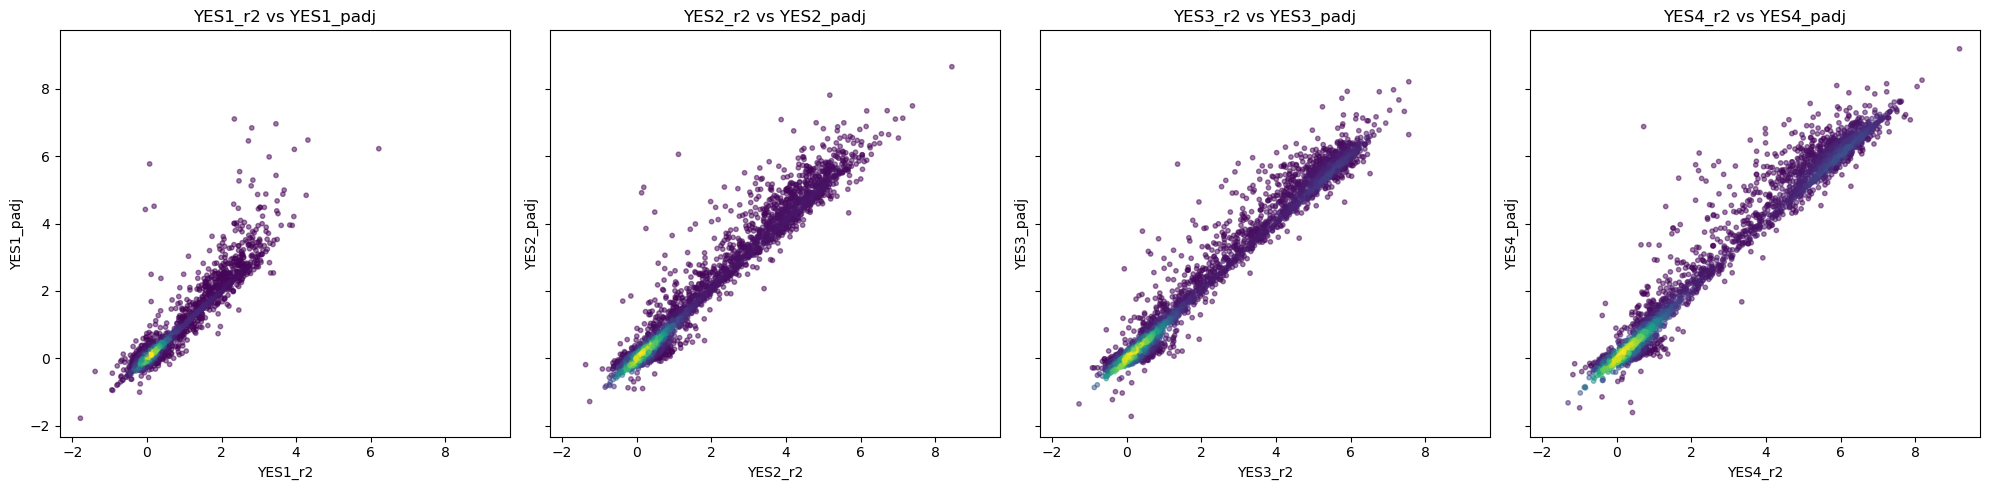

In [104]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    x = merged_gene_level_statistics[f"YES{i+1}_r2"]
    y = merged_gene_level_statistics[f"YES{i+1}_padj"]
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x, y, alpha=0.5, c=z, s=10)
    ax.set_xlabel(f"YES{i+1}_r2")
    ax.set_ylabel(f"YES{i+1}_padj")
    ax.set_title(f"YES{i+1}_r2 vs YES{i+1}_padj")

plt.tight_layout()
plt.show()
plt.close()

## 6. Compare the LD_YYS1328 with the HD_1328_padj

In [111]:
LD_rsquare_based_gene_level_statistics = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/Spore2YES6_1328/17_gene_level_depletion_analysis/Gene_level_statistics.tsv", sep="\t")
LD_HD_merged_gene_level_statistics = pd.merge(LD_rsquare_based_gene_level_statistics, padj_based_gene_level_statistics, suffixes=["_r2", "_padj"], how="inner", on=["Systematic ID", "Name", "FYPOviability", "DeletionLibrary_essentiality"])

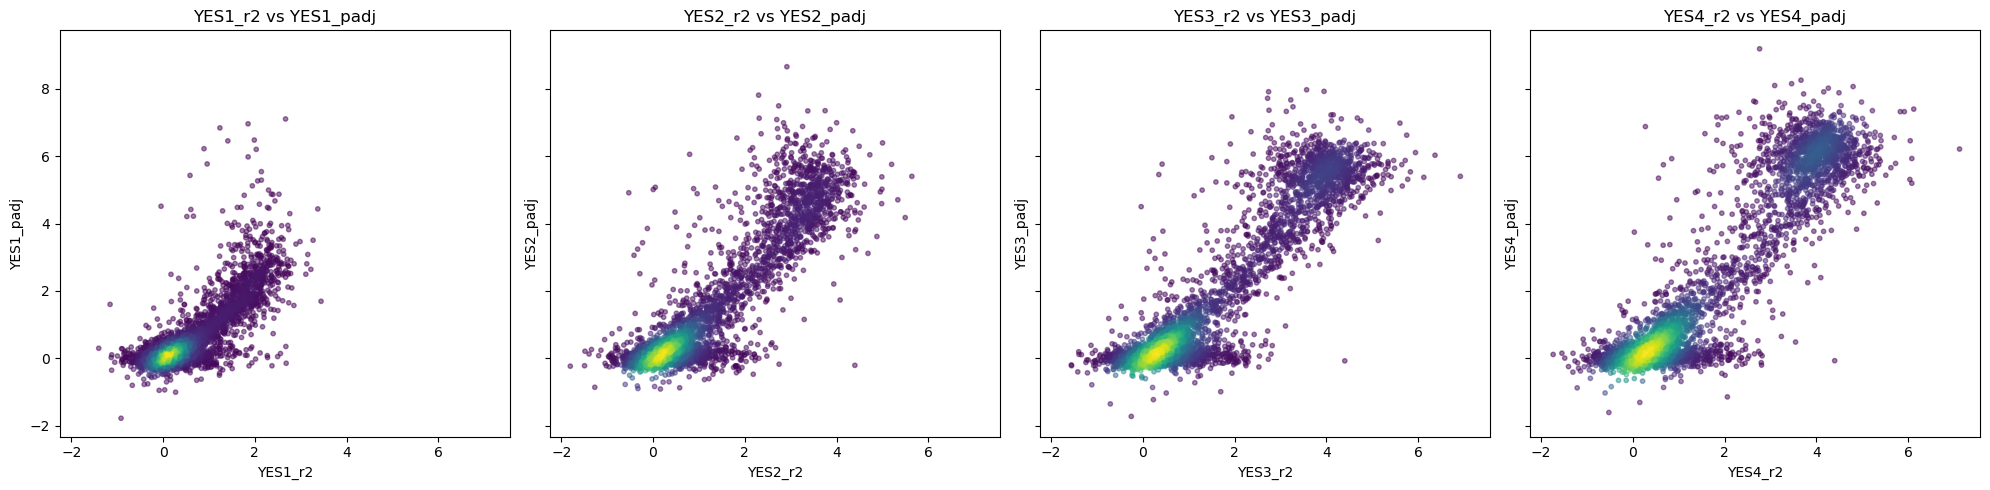

In [113]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    x = LD_HD_merged_gene_level_statistics[f"YES{i+1}_r2"]
    y = LD_HD_merged_gene_level_statistics[f"YES{i+1}_padj"]
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x, y, alpha=0.5, c=z, s=10)
    ax.set_xlabel(f"YES{i+1}_r2")
    ax.set_ylabel(f"YES{i+1}_padj")
    ax.set_title(f"YES{i+1}_r2 vs YES{i+1}_padj")

plt.tight_layout()
plt.show()
plt.close()